In [9]:
import numpy as np

class Counter(dict):
    def __init__(self, include_zeros = False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.top_three_list = []
        self.include_zeros = include_zeros
    
    def increment(self, item, delta = 1):
        new_val = delta + self.pop(item, 0)
        if new_val > 0:
            self[item] = new_val
        if self.include_zeros:
            self.update_top_three(item, new_val)
        else:
            self.update_top_three_no_zero(item, new_val)
    
    def update_top_three(self, item, value):
        counter = 0
        ## check if the key already exists in the top-three and update its value if it does
        for (k, v) in self.top_three_list:
            if item == k:
                counter += 1
                self.top_three_list.remove((k, v))
                self.top_three_list.append((k, value))
                self.top_three_list.sort(key=lambda x: x[1], reverse=True)
        ## check if there is space first [will always be space because we shorten list to three in final step], then check that the key does not already exist, and if so append it to the list
        if len(self.top_three_list) < 4:
            if counter == 0:
                self.top_three_list.append((item, value))
                self.top_three_list.sort(key=lambda x: x[1], reverse=True)
        ## take only top three of the elements of the list; and return only the values not the keys (i.e. the counts)
        self.top_three()

    def update_top_three_no_zero(self, item, value):
        if item != 0:
            counter = 0
            ## check if the key already exists in the top-three and update its value if it does
            for (k, v) in self.top_three_list:
                if item == k:
                    counter += 1
                    self.top_three_list.remove((k, v))
                    self.top_three_list.append((k, value))
                    self.top_three_list.sort(key=lambda x: x[1], reverse=True)
            ## check if there is space first [will always be space because we shorten list to three in final step], then check that the key does not already exist, and if so append it to the list
            if len(self.top_three_list) < 4:
                if counter == 0:
                    self.top_three_list.append((item, value))
                    self.top_three_list.sort(key=lambda x: x[1], reverse=True)
             ## take only top three of the elements of the list; and return only the values not the keys (i.e. the counts)
            self.top_three()

    def top_three(self):
        final_counts = []
        self.top_three_list = self.top_three_list[:3]
        for (k, v) in self.top_three_list:
            final_counts.append(v)
        return final_counts


def y(x):
    return 2**x

def find_tranformation_matrix(b, E, N, Tmax, stopping_crit = 0, zero_counts = False):

    M = np.shape(E)[0]
    ## find the number of events that occur in the interval from T = 0 to T = Tmax
    n = np.random.poisson(lam = Tmax*(N+b*M))

    ## find times for all events
    times = np.sort(np.random.uniform(0, Tmax, n))
    R = np.zeros(n, dtype = int)

    ##making a spatial plot
    spatial1 = np.zeros(n, dtype = int)
    spatial2 = np.zeros(n, dtype = int)
    spatial3 = np.zeros(n, dtype = int)
    
    X = [2**i for i in range(N)][::-1]

    ## default is to not include zero counts in the top three, set zero_counts = True in function call to include zero counts
    counts = Counter(include_zeros = zero_counts)
    for element in X:
        counts.increment(element, 1)

    # run simulation
    for t in range(n):
        
        if np.random.random() < N/(N + b*M):

            i = np.random.randint(N)

            if X[i] != 0:
                
                counts.increment(X[i], -1)

                X[i] = 0

                counts.increment(0, 1)
        else:

            i,j = E[np.random.randint(M)]

            if (X[i] != 0 or X[j] != 0) and X[i] != X[j]:
                    
                new = X[i] | X[j]
                counts.increment(X[i], -1)
                counts.increment(X[j], -1)
                counts.increment(new, 2)
                X[i] = X[j] = new
                
        R[t] = non_zero_distinct_rows = len(counts) - (0 in counts)
        
        ## making a spatial plot
        top_three = counts.top_three()
        if len(top_three) == 3:
            spatial1[t] = top_three[0]
            spatial2[t] = top_three[1]
            spatial3[t] = top_three[2]
        elif len(top_three) == 2:
            spatial1[t] = top_three[0]
            spatial2[t] = top_three[1]
            spatial3[t] = 0
        elif len(top_three) == 1:
            spatial1[t] = top_three[0]
            spatial2[t] = 0
            spatial3[t] = 0
        elif len(top_three) == 0:
            spatial1[t] = 0
            spatial2[t] = 0
            spatial3[t] = 0
        
        ## break the simulation because the pseudo mixing time has been found (the number of distinct rows and thus distinct columns is 2 or extinction, depending)

        if non_zero_distinct_rows == stopping_crit:
            times = times[:t+1]
            R = R[:t+1]
            spatial1 = spatial1[:t+1]
            spatial2 = spatial2[:t+1]
            spatial3 = spatial3[:t+1]
            break

    return times, R, spatial1, spatial2, spatial3


In [10]:
N =  4000
M = 3*N
Tmax = 500
## at the transition -- try again with the epidemic 
b = 5

## random edge matrix
E = np.random.randint(0,N,size=2*M).reshape((N*3, 2))

## run all the way to extinction time
times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b, E, N, Tmax, 0)



Check if the new class is working -- Apears so! :D

In [11]:
p_mix_index = np.min(np.where(R==1)[0])
t_p_mixing = times[p_mix_index]
print("Pseudo mixing time: ", t_p_mixing)

Pseudo mixing time:  2.1635043373888774


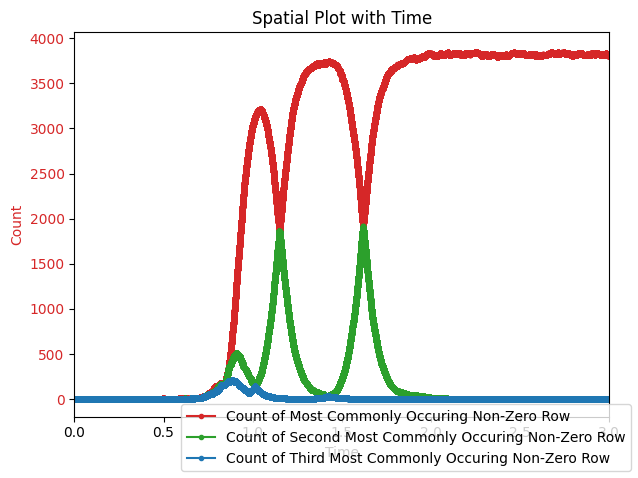

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Count', color=color)
ax1.plot(times, spatial1, color=color, marker = 'o', markersize = 3, label= 'Count of Most Commonly Occuring Non-Zero Row')
ax1.tick_params(axis='y', labelcolor=color)
color = 'tab:green'
ax1.plot(times, spatial2, color=color, marker = 'o', markersize = 3, label= 'Count of Second Most Commonly Occuring Non-Zero Row')
color = 'tab:blue'
ax1.plot(times, spatial3, color=color, marker = 'o', markersize = 3, label= 'Count of Third Most Commonly Occuring Non-Zero Row')
fig.legend(loc = 'lower right')
plt.xlim(0, 3)
plt.title('Spatial Plot with Time')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [2]:
N =  4000
M = 3*N
Tmax = 500

## random edge matrix
E = np.random.randint(0,N,size=2*M).reshape((N*3, 2))

First, we are getting the lists for s1*, s2*, s3*. As in, we are keeping the zero-counts parameter set to False

In [3]:
b = np.linspace(0.002, 0.5, 10)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = 0
    maxs2 = 0
    maxs3 = 0
    for j in range(5):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0)
        max_s1 = np.argmax(spatial1)
        maxs1 += spatial1[max_s1]
        max_s2 = np.argmax(spatial2)
        maxs2 += spatial2[max_s2]
        max_s3 = np.argmax(spatial3)
        maxs3 += spatial3[max_s3]
    print(maxs2/5)
    s1.append(maxs1/5)
    s2.append(maxs2/5)
    s3.append(maxs3/5)

print(s1)
print(s2)
print(s3)


2.0
5.2
10.8
45.4
210.4
171.8
404.2
500.6
571.6
494.6
[2.6, 6.2, 14.2, 98.8, 1062.6, 1618.8, 1987.8, 2257.0, 2471.2, 2626.0]
[2.0, 5.2, 10.8, 45.4, 210.4, 171.8, 404.2, 500.6, 571.6, 494.6]
[2.0, 5.0, 9.0, 29.6, 49.8, 116.0, 131.6, 228.6, 195.0, 199.0]


In [4]:
b = np.linspace(0.6, 5, 7)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = 0
    maxs2 = 0
    maxs3 = 0
    for j in range(5):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0)
        max_s1 = np.argmax(spatial1)
        maxs1 += spatial1[max_s1]
        max_s2 = np.argmax(spatial2)
        maxs2 += spatial2[max_s2]
        max_s3 = np.argmax(spatial3)
        maxs3 += spatial3[max_s3]
    print(maxs2/5)
    s1.append(maxs1/5)
    s2.append(maxs2/5)
    s3.append(maxs3/5)

print(s1)
print(s2)
print(s3)

860.2
897.8
1354.8
1160.4
1481.4
1554.4
998.6
[2859.0, 3498.6, 3678.2, 3769.8, 3822.0, 3854.6, 3876.4]
[860.2, 897.8, 1354.8, 1160.4, 1481.4, 1554.4, 998.6]
[262.2, 421.0, 570.2, 607.4, 552.2, 505.0, 480.4]


Now we set the zero counts to True 

In [5]:
b = np.linspace(0.002, 0.5, 10)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = 0
    maxs2 = 0
    maxs3 = 0
    for j in range(5):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0, True)
        max_s1 = np.argmax(spatial1)
        maxs1 += spatial1[max_s1]
        max_s2 = np.argmax(spatial2)
        maxs2 += spatial2[max_s2]
        max_s3 = np.argmax(spatial3)
        maxs3 += spatial3[max_s3]
    print(maxs2/5)
    s1.append(maxs1/5)
    s2.append(maxs2/5)
    s3.append(maxs3/5)

print(s1)
print(s2)
print(s3)

2.2
6.2
16.8
127.8
1069.4
1618.4
1992.4
2000.0
1831.6
1662.6
[4000.0, 4000.0, 4000.0, 3999.2, 3279.0, 2716.6, 2343.2, 2259.4, 2475.0, 2634.4]
[2.2, 6.2, 16.8, 127.8, 1069.4, 1618.4, 1992.4, 2000.0, 1831.6, 1662.6]
[2.0, 5.0, 10.6, 44.8, 228.2, 311.8, 417.6, 487.8, 470.6, 786.6]


In [6]:
b = np.linspace(0.6, 5, 7)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = 0
    maxs2 = 0
    maxs3 = 0
    for j in range(5):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0, True)
        max_s1 = np.argmax(spatial1)
        maxs1 += spatial1[max_s1]
        max_s2 = np.argmax(spatial2)
        maxs2 += spatial2[max_s2]
        max_s3 = np.argmax(spatial3)
        maxs3 += spatial3[max_s3]
    print(maxs2/5)
    s1.append(maxs1/5)
    s2.append(maxs2/5)
    s3.append(maxs3/5)

print(s1)
print(s2)
print(s3)

1414.0
1253.4
1701.0
1504.2
1473.0
1488.8
1557.0
[2851.0, 3489.0, 3681.6, 3767.4, 3822.2, 3856.6, 3877.2]
[1414.0, 1253.4, 1701.0, 1504.2, 1473.0, 1488.8, 1557.0]
[723.0, 597.6, 610.2, 614.6, 800.0, 428.8, 537.2]


In [18]:
print(np.linspace(0.6, 5, 7))

[0.6        1.33333333 2.06666667 2.8        3.53333333 4.26666667
 5.        ]


In [ ]:
b = [0.002, 0.05733333, 0.11266667, 0.168, 0.22333333, 0.27866667, 0.334, 0.38933333, 0.44466667, 0.5 ,  0.6, 1.33333333, 2.06666667, 2.8 , 3.53333333, 4.26666667, 5.]
s1star = [2.6, 6.2, 14.2, 98.8, 1062.6, 1618.8, 1987.8, 2257.0, 2471.2, 2626.0, 2859.0, 3498.6, 3678.2, 3769.8, 3822.0, 3854.6, 3876.4]
s2star = [2.0, 5.2, 10.8, 45.4, 210.4, 171.8, 404.2, 500.6, 571.6, 494.6, 860.2, 897.8, 1354.8, 1160.4, 1481.4, 1554.4, 998.6]
s3star = [2.0, 5.0, 9.0, 29.6, 49.8, 116.0, 131.6, 228.6, 195.0, 199.0, 262.2, 421.0, 570.2, 607.4, 552.2, 505.0, 480.4]
s1 = [4000.0, 4000.0, 4000.0, 3999.2, 3279.0, 2716.6, 2343.2, 2259.4, 2475.0, 2634.4, 2851.0, 3489.0, 3681.6, 3767.4, 3822.2, 3856.6, 3877.2]
s2 = [2.2, 6.2, 16.8, 127.8, 1069.4, 1618.4, 1992.4, 2000.0, 1831.6, 1662.6, 1414.0, 1253.4, 1701.0, 1504.2, 1473.0, 1488.8, 1557.0]
s3 = [2.0, 5.0, 10.6, 44.8, 228.2, 311.8, 417.6, 487.8, 470.6, 786.6, 723.0, 597.6, 610.2, 614.6, 800.0, 428.8, 537.2]

Now, we make our list of value of S2* and S3* when S1* is maximum

In [7]:
b = np.linspace(0.002, 5, 15)
s1 = []
s2 = []
s3 = []
for i in range(len(b)):
    maxs1 = 0
    maxs2 = 0
    maxs3 = 0
    for j in range(5):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 0)
        max_s1 = np.argmax(spatial1)
        maxs1 += spatial1[max_s1]
        maxs2 += spatial2[max_s1]
        maxs3 += spatial3[max_s1]
    print(maxs2/5)
    s1.append(maxs1/5)
    s2.append(maxs2/5)
    s3.append(maxs3/5)

print(s1)
print(s2)
print(s3)


1.4
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[2.4, 2130.8, 3039.2, 3371.8, 3531.8, 3633.0, 3697.8, 3740.4, 3776.2, 3803.2, 3824.4, 3839.4, 3856.0, 3870.4, 3882.6]
[1.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
s1points = [2.4, 2130.8, 3039.2, 3371.8, 3531.8, 3633.0, 3697.8, 3740.4, 3776.2, 3803.2, 3824.4, 3839.4, 3856.0, 3870.4, 3882.6]
s2points = [1.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
s3points = [1.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [8]:
b = np.linspace(0.002, 0.5, 15)

p_mixing_times = []

for i in range(len(b)):
    t_p_mixing = 0
    for j in range(10):
        times, R, spatial1, spatial2, spatial3 = find_tranformation_matrix(b[i], E, N, Tmax, 1)
        p_mix_index = np.min(np.where(R==1)[0])
        t_p_mixing += times[p_mix_index]
    p_mixing_times.append(t_p_mixing/10)
    print(t_p_mixing/10)

print(p_mixing_times)


7.582123566665767
10.097434711607457
11.931214412872528
17.25010594207508
29.982398887881125
132.4320903465923
60.500126336034725
40.99115921458893
32.47528465776249
26.999036566925366
22.24572141620232
20.031470348972025
17.388974978575792
16.759107753285587
14.370689054196879
[7.582123566665767, 10.097434711607457, 11.931214412872528, 17.25010594207508, 29.982398887881125, 132.4320903465923, 60.500126336034725, 40.99115921458893, 32.47528465776249, 26.999036566925366, 22.24572141620232, 20.031470348972025, 17.388974978575792, 16.759107753285587, 14.370689054196879]


In [ ]:
btimes = np.linspace(0.002, 0.5, 15)
pmixing = [7.582123566665767, 10.097434711607457, 11.931214412872528, 17.25010594207508, 29.982398887881125, 132.4320903465923, 60.500126336034725, 40.99115921458893, 32.47528465776249, 26.999036566925366, 22.24572141620232, 20.031470348972025, 17.388974978575792, 16.759107753285587, 14.370689054196879]

Plot Results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spatial Plot')
ax1.set_ylabel('Spreading Rate', color=color)
ax1.plot(b, s1star, color=color, marker = 'o', label= 'Count of Most Commonly Occuring Non-Zero Row')
ax1.tick_params(axis='y', labelcolor=color)
color = 'tab:green'
ax1.plot(b, s2star, color=color, marker = 'o', label= 'Count of Second Most Commonly Occuring Non-Zero Row')
color = 'tab:blue'
ax1.plot(b, s3star, color=color, marker = 'o', label= 'Count of Second Most Commonly Occuring Non-Zero Row')
ax2 = ax1.twinx()
color = 'tab:black'
ax2.plot(btimes, pmixing, color=color, marker = 'o', markersize = 2, label= 'Pseudo Mixing Time', linestyle = '--')
ax2.set_ylabel('Pseudo Mixing Time', color=color)

fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Spreading Rate')
ax1.set_ylabel('Row Count', color=color)
ax1.plot(b, s1, color=color, marker = 'o', label= 'Count of Most Commonly Occuring Row')
ax1.tick_params(axis='y', labelcolor=color)
color = 'tab:green'
ax1.plot(b, s2, color=color, marker = 'o', label= 'Count of Second Most Commonly Occuring Row')
color = 'tab:blue'
ax1.plot(b, s3, color=color, marker = 'o', label= 'Count of Second Most Commonly Occuring Row')

fig.legend(loc = 'lower right')
plt.title('Spatial Plot with Spreading Rate (Including Zero Rows)')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
